This notebook walks through how to run a CCG on sleep deprivation data.

In [22]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
    elif environ["HOSTNAME"] == "lnx00035": # BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pingouin as pg

from neuropy.analyses.placefields import Pf1D
from neuropy.core.neurons import Neurons
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO
from neuropy.core.session import ProcessData
import neuropy.analyses.correlations as correlations

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in sleep deprivation session

In [12]:
sorted(data_dir.glob("*.eeg"))

[PosixPath('/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46.artifactchan.eeg'),
 PosixPath('/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46_thetachan.eeg'),
 PosixPath('/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46_thetachan_oriens.eeg'),
 PosixPath('/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46_thetachan_radiatum.eeg')]

In [14]:
data_dir = Path("/data/Clustering/sessions/RatU/RatUDay4SD")
sess = ProcessData(data_dir)

### Load in neurons

In [20]:
# load in all neurons and neurons which were stable across sleep
sess.neurons = Neurons.from_dict(np.load(sess.filePrefix.with_suffix(".neurons.npy"), allow_pickle=True).item())
sess.neurons_stable = Neurons.from_dict(np.load(sess.filePrefix.with_suffix(".neurons.stable.npy"), allow_pickle=True).item())
sess.neurons_stable

Neurons
 n_neurons: 185
 t_start: 0.0
 t_stop: 48283.0336
 neuron_type: ['inter' 'mua' 'pyr']

In [23]:
# Select inhibitory neurons
interneurons = sess.neurons_stable.get_neuron_type("inter")
interneurons

Neurons
 n_neurons: 16
 t_start: 0.0
 t_stop: 48283.0336
 neuron_type: ['inter']

### Run CCG

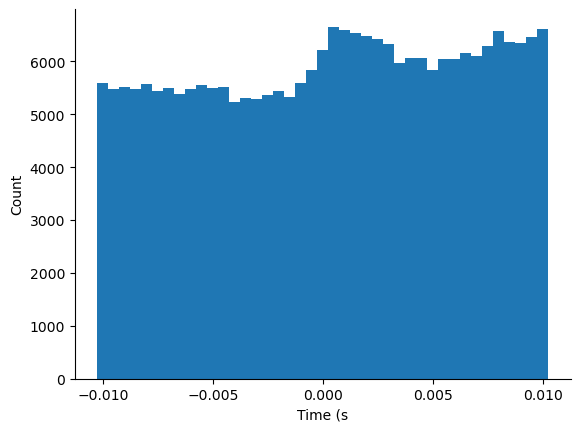

In [45]:
# get ccg between neurons 0 and 1
neuron_inds = [0, 1]
bin_size = 0.0005
window_size = 0.02
ccg = correlations.spike_correlations(interneurons, neuron_inds, sample_rate=sess.recinfo.dat_sampling_rate,
                                      bin_size=bin_size, window_size=window_size)

_, ax = plt.subplots()
bins = np.arange(-window_size / 2, window_size / 2 + bin_size, bin_size)
ax.bar(bins, ccg[0, 1], width=bin_size)
ax.set_xlabel("Time (s")
ax.set_ylabel("Count")
sns.despine(ax=ax)

### Run CCG for specific time windows

In [34]:
# Load in experimental time epochs
sess.paradigm = Epoch.from_file(sess.filePrefix.with_suffix(".paradigm.npy"))
sess.paradigm

6 epochs
Snippet: 
    start   stop label
0      0   9410   pre
1   9411  12546  maze
2  12547  30564    sd
3  12547  45160  post
4  30565  45160    rs

In [38]:
# Grab sleep deprivation (SD) and recovery sleep (RS) epochs
sd_times = sess.paradigm["sd"].flatten()
rs_times = sess.paradigm["rs"].flatten()
sd_times

array([12547, 30564])

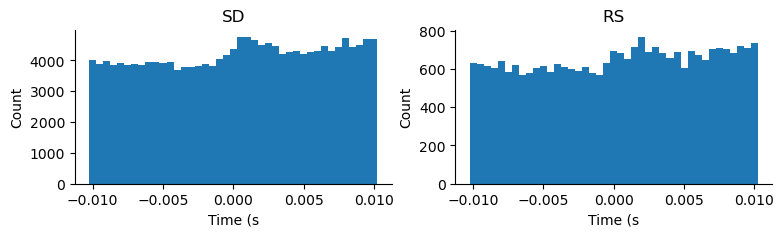

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(9, 2))
for epoch_name, time_lims, ax in zip(["SD", "RS"], [sd_times, rs_times], axs):
    interneurons_slice = interneurons.time_slice(*time_lims)
    ccg = correlations.spike_correlations(interneurons_slice, neuron_inds, sample_rate=sess.recinfo.dat_sampling_rate,
                                          bin_size=bin_size, window_size=window_size)
    
    bins = np.arange(-window_size / 2, window_size / 2 + bin_size, bin_size)
    ax.bar(bins, ccg[0, 1], width=bin_size)
    ax.set_xlabel("Time (s")
    ax.set_ylabel("Count")
    ax.set_title(epoch_name)
sns.despine(fig=fig)